# Fine-tune BERT for sentence-pair classification

## Introduction 

You will learn in this notebook how to fine-tune BERT-based models for the **sentence-pair classification** task. This TensorFlow implementation leverages the Hugging face *transformers* and *datasets* libraries to download pre-trained models, enable quick research experiments and evaluation metrics.

This task is part of the semantic textual similarity problem. You have two pair of questions and you want to model the textual interaction between them.

The dataset used in this notebook is Quora Question Pair (QQP) which is part of the GLUE benchmark : you have two sentences(questions) and you want to predict if one sentence is the paraphrase of the other one. The evaluation metrics are F1 and accuracy.

The main features of this tutorial are : 
- End-to-end ML implementation (training, validation, prediction, evaluation)
- Usage of your own datasets 
- Facilitation of quick experiments with other BERT-based models (BERT, ALBERT, ...)
- Comparison of finetuned model with model w/o finetuning.

## Installation of libraries and imports

In [ ]:
!pip -qq install datasets transformers[sentencepiece]
# !pip install transformers[sentencepiece]

     |████████████████████████████████| 365 kB 20.3 MB/s 
     |████████████████████████████████| 4.7 MB 66.3 MB/s 
     |████████████████████████████████| 115 kB 74.0 MB/s 
     |████████████████████████████████| 120 kB 81.5 MB/s 
     |████████████████████████████████| 212 kB 84.3 MB/s 
     |████████████████████████████████| 127 kB 110.8 MB/s 
     |████████████████████████████████| 6.6 MB 76.9 MB/s 
     |████████████████████████████████| 1.3 MB 61.9 MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import copy

import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
pd.set_option('max_colwidth', 400)

## Dataset Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/sentence_pair_classification_data/train.csv')


In [ ]:
train.sample(5)

,question1,question2,label,idx
347819,"Book, only if 2 lower berths are allotted?","In a ticket booked for one couple, if one pass...",0,347819
285676,What is months at level in Accenture?,What are the corresponding ladder levels in ac...,0,285676
362837,Will I lose weight if I fast?,Can I lose weight by fasting?,1,362837
125744,What bike is best for urban commuting with ste...,What is the best all-mountain bike?,0,125744
145128,How can I score 97% in 10th board exams by stu...,Is it possible to complete 10th grade syllabus...,0,145128


In [ ]:
train.shape

(363846, 4)

## Reading data as Huggingface dataset object

In [ ]:
dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/sentence_pair_classification_data/train.csv',\
                                          'valid':'/content/drive/MyDrive/sentence_pair_classification_data/val.csv',
                                              'test': '/content/drive/MyDrive/sentence_pair_classification_data/test.csv'},)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-47edc8def3442730/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    valid: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

In [ ]:
model_checkpoint = "bert-base-cased"
batch_size = 32

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Sample Tokenization

In [ ]:
tokenizer(train.question1[0], train.question2[0], 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=100,  
                                      return_tensors='tf',return_token_type_ids = True)  # Return torch.Tensor objects

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  1731,  1110,  1103,  1297,  1104,   170, 12523,  2377,
          136,  7426,  1128,  5594,  1240,  1319,  5758,   136,   102,
         5979,  1634,  1104,  3073, 20488,  2116,  1110,  1536,  1111,
         1103, 12211,   179,  1233,  6451,  1571,   136,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Tokenizer for Model Training

In [ ]:
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length = 75)

In [ ]:
pre_tokenizer_columns = set(dataset["train"].features)

In [ ]:
pre_tokenizer_columns

{'idx', 'label', 'question1', 'question2'}

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True, )

  0%|          | 0/364 [00:00<?, ?ba/s]

  0%|          | 0/41 [00:00<?, ?ba/s]

  0%|          | 0/391 [00:00<?, ?ba/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 363846
    })
    valid: Dataset({
        features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 390965
    })
})

In [ ]:


tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['input_ids', 'token_type_ids', 'attention_mask']


# Data padding and batching

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [ ]:
# sample train batch
z = next(iter(tf_train_dataset))

In [ ]:
# sample decoded string
tokenizer.decode(z[0]['input_ids'][0])

'[CLS] What is the difference between sushi and Gimbap? Other than the countries that they are from. [SEP] Where I can get Japanese pancakes in NYC? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
# Number of classes in the classification task
num_labels = train.label.nunique()

In [ ]:
num_labels

2

# Loading the model checkpoint

In [ ]:


model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels)



All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Hyperparameters

In [ ]:

# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

## Closer look at the learning rate scheduler

In [ ]:
lr_schedule = []
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr_schedule.append(lr_scheduler.initial_learning_rate * decay)


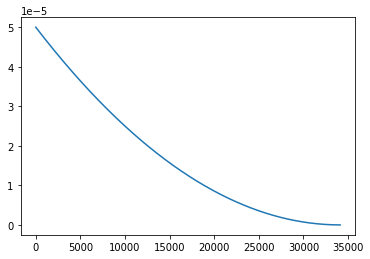

In [ ]:
plt.plot(lr_schedule)

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

In [ ]:
model.save_pretrained("/content/drive/MyDrive/saved_model_epoch2/")

# Scoring

## Sample Scoring

In [ ]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/qqp_finetuned_model/',num_labels = num_labels)

Some layers from the model checkpoint at /content/drive/MyDrive/qqp_finetuned_model/ were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/qqp_finetuned_model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# Checking similarity of input sentence pair

In [ ]:
def check_similarity(question1, question2):
  tokenizer_output = tokenizer(question1, question2, truncation=True, return_token_type_ids=True, max_length = 75, return_tensors = 'tf')
  logits = trained_model(**tokenizer_output)["logits"]
  predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
  if predicted_class_id == 1:
    return "Both questions mean the same"
  else:
    return "Both the questions are different."


In [ ]:
check_similarity("Why are people so obsessed with cricket?", "Why are people so obsessed with football?")

'Both the questions are different.'

In [ ]:
check_similarity("Why are people so obsessed with cricket?", "Why do people like cricket?")

'Both questions mean the same'